# Inverse problem for the electron transfer system

## Problem setup

We will solve an inverse problem for ET systems for unknowns $D$ and $D^+$

$$
\begin{aligned}
    \partial_t C_Q - \partial_z(D\partial_z C_Q) &= 0, \quad && \quad (t, z) \in [0,2t_{\lambda}] \times [0, z_1],\\
   \partial_t C_{Q^+} - \partial_z(D^+\partial_z C_{Q^+}) &= 0, \quad &&\quad (t, z) \in [0,2t_{\lambda}] \times [0, z_1].
\end{aligned}
$$

Subject to the boundary conditions:

$$
\begin{aligned}
\partial_z C_{i}(t, z_1) &= 0, \quad \forall i \in {Q, Q^+} \quad && \quad \forall (t, z) \in [0,2t_{\lambda}] \times [0, z_1],\\
D\partial_z C_Q(t, 0)  &= K_f(t)C_Q(t, 0) - K_b(t)C_{Q^+}(t, 0), \quad && \quad \forall t \in [0,2t_{\lambda}], \\
D^+\partial_z C_{Q^+}(t, 0) &= -K_f(t)C_Q(t, 0) + K_b(t)C_{Q^+}(t, 0), \quad && \quad \forall t \in [0,2t_{\lambda}].
\end{aligned}
$$

And the initial condition:

$$
\begin{equation}
C_Q(0, z) = 1, \quad C_{Q^+}(0, z) = 0, \quad \quad \forall z\in [0,z_1].
\end{equation}
$$

Here $C_{i}(t,z)\in\mathbb{R}$ is the dimensionless concentration of the species $i\in \{\mathbf{Q},\mathbf{Q}^{+}\}$ and $D^+\in\mathbb{R}$ is the dimensionless diffusion of the specie $\mathbf{Q}^{+}$. The heterogeneous electron transfer rate constants, $k_b, k_f$, can  be written in its dimensionless form, $K_b, K_f$,  as follows:

$$
\begin{equation}
K_f = K_0\exp[(1-\delta)P], \quad \quad K_b = K_0\exp[(-\delta) P].
\end{equation}
$$

Where the dimensionless potential, $P$, in terms of the dimensionless time, is given by:

$$
\begin{align}
P = \left\lbrace
\begin{array}{ll}
P_1 + t , \; 0\leq t\leq t_\lambda\\
P_2 -  (t - t_\lambda) , \; t_\lambda\leq t\leq 2t_\lambda
\end{array} 
\right.,\qquad
t_\lambda = P_2-P_1,
\end{align}
$$

With $P_1$ and $P_2$ respectively the dimensionless initial and reverse potential. The dimensionless current, $G$, is given by:

$$
\begin{equation}
G(t) = \partial_zC_Q(t, 0)  = K_f(t)C_Q(t, 0) - K_b(t)C_{Q^+}(t, 0), \quad \forall t\in [0,2t_{\lambda}].
\end{equation}
$$

In [1]:
import numpy as np
# Set constants
pi = np.pi
delta = 0.5                       # Electron transfer coefficient
# D_A = 1                           # Ratio of diffusion coefficient of A
# D_plus = 1                        # Ratio of diffusion coefficient of B
K0 = 20                           # Dimensionles electron transfer rate constant
p1 = -10                          # Starting dimensionless potential
p2 = 10                           # End dimensionless potential
D_depth = 5*(2*pi*(p2+8))**0.5
#D_depth = 6*np.sqrt(D*t_max)
t_lambda = p2-p1
ht = 0.1                          # Dimesionless time interval
C_A0 = 1                          # tf.constant(1, dtype=DTYPE)
C_B0 = 0                          # tf.constant(0, dtype=DTYPE)

In [2]:
def dimensionless_potential(t):
    p = np.where(t <= t_lambda, p1 + t, p2 - (t - t_lambda))
    return p

def electron_transfer_rates(P):
    Kf = K0 * np.exp((1 - delta) * P)
    Kb = K0 * np.exp((-delta) * P)
    return Kf, Kb

#### First step to recover the diffusion coefficient $D$ and $D^+$ given measurement $C_{Q_i}$ = $C_Q(t_i, z_i)$ and $C_{Q^+_i}$ = $C_{Q^+}(t_i, z_i)$

#### Load training data

In [3]:
import scipy

def gen_traindata():
    mat = scipy.io.loadmat('PINNS.mat')
    aa = mat['Synthetic_Data']
    bb = aa[0, 0]
    Cq = bb[0]
    Cqp = bb[1]
    Z_i = bb[2][0]
    T_i = bb[3][0]
    # G = bb[4][0]
    # pot = bb[5][0]

    X, T = np.meshgrid(Z_i, T_i)
    X = np.reshape(X, (-1, 1))
    T = np.reshape(T, (-1, 1))
    Xgrid = np.hstack((X, T))
    Cq = np.reshape(Cq, (-1, 1))
    Cqp = np.reshape(Cqp, (-1, 1))
    return Xgrid, Cq, Cqp

## Implementation

In [4]:
import deepxde as dde
import numpy as np

2024-07-07 15:19:01.138705: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-07 15:19:02.619670: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-07-07 15:19:02.619759: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2024-07-07 15:19:02.619772: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like t

Instructions for updating:
non-resource variables are not supported in the long term


2024-07-07 15:19:06.687444: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2024-07-07 15:19:06.687495: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [5]:
# We define the unknown variables D and D_plus with initial guesses of 5 and 2
D = dde.Variable(5.0)
D_plus = dde.Variable(2.0)

In [6]:
geom = dde.geometry.Interval(0.0, D_depth)
timedomain = dde.geometry.TimeDomain(0.0, 2*t_lambda)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

In [7]:
def pde(x, y):
    cq_t = dde.grad.jacobian(y, x, i=0, j=1)
    cqp_t = dde.grad.jacobian(y, x, i=1, j=1)
    cq_zz = dde.grad.hessian(y, x, component=0, i=0, j=0)
    cqp_zz = dde.grad.hessian(y, x, component=1, i=0, j=0)
    eq1 = cq_t - D*cq_zz
    eq2 = cqp_t - D_plus*cqp_zz
    return [eq1, eq2]

In [8]:
def boundary_left(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], 0.0)

def boundary_right(x, on_boundary):
    return on_boundary and dde.utils.isclose(x[0], D_depth)

def initial(x, on_initial):
    return on_initial and dde.utils.isclose(x[1], 0.0)

In [9]:
def robin_boundary_condition_cq(x, y):
    t = x[:, 1]
    cq = y[:, 0]
    cqp = y[:, 1]
    P = dimensionless_potential(t)
    k_f, k_b = electron_transfer_rates(P)
    r = (1.0/D)*(k_f*cq - k_b*cqp)
    return r

def robin_boundary_condition_cqp(x, y):
    t = x[:, 1]
    cq = y[:, 0]
    cqp = y[:, 1]
    P = dimensionless_potential(t)
    k_f, k_b = electron_transfer_rates(P)
    r = (1.0/D_plus)*(-k_f*cq + k_b*cqp)
    return r

In [10]:
observe_x, Cq, Cqp = gen_traindata()
observe_y1 = dde.icbc.PointSetBC(observe_x, Cq, component=0)
observe_y2 = dde.icbc.PointSetBC(observe_x, Cqp, component=1)

In [11]:
bc1 = dde.icbc.NeumannBC(geomtime, lambda x: 0.0, boundary_right, component=0)
bc2 = dde.icbc.NeumannBC(geomtime, lambda x: 0.0, boundary_right, component=1)
bc3 = dde.icbc.RobinBC(geomtime, robin_boundary_condition_cq, boundary_left, component=0)
bc4 = dde.icbc.RobinBC(geomtime, robin_boundary_condition_cqp, boundary_left, component=1)
ic1 = dde.icbc.IC(geomtime, lambda x: 1.0, initial, component=0)
ic2 = dde.icbc.IC(geomtime, lambda x: 0.0, initial, component=1)

In [16]:
# Define the PDE problem and configurations of the network:
data = dde.data.TimePDE(
    geomtime,
    pde,
    [ic1, ic2, bc1, bc2, bc3, bc4, observe_y1, observe_y2],
    num_domain=20000,
    num_boundary=1000,
    anchors=observe_x,
    num_initial=1000,
    num_test=2000
)

In [17]:
layer_size = [2] + [20] * 3 + [2]
activation = 'tanh'
initializer = 'Glorot uniform'
net = dde.nn.FNN(layer_size, activation, initializer)

In [18]:
model = dde.Model(data, net)
loss_weights = [1, 1, 1, 1, 1, 1, 1e-5, 1e-5, 1, 1]
model.compile("adam", lr=0.001, loss_weights=loss_weights, external_trainable_variables=[D, D_plus])
variable = dde.callbacks.VariableValue([D, D_plus], period=1000, filename="variables.dat")

Compiling model...
Building feed-forward neural network...
'build' took 0.114308 s

'compile' took 1.737581 s



Training model...

Step      Train loss                                                                                              Test loss                                                                                               Test metric
0         [4.86e-03, 4.76e-03, 2.09e+00, 6.15e-01, 2.72e-05, 7.19e-05, 4.50e-03, 2.82e-02, 1.22e+00, 1.84e-01]    [3.86e-03, 1.70e-03, 2.09e+00, 6.15e-01, 2.72e-05, 7.19e-05, 4.50e-03, 2.82e-02, 1.22e+00, 1.84e-01]    []  
1000      [2.98e-03, 1.50e-03, 4.12e-05, 1.47e-04, 1.89e-06, 5.71e-07, 2.19e-04, 1.04e-03, 1.60e-02, 1.28e-02]    [1.91e-03, 6.79e-04, 4.12e-05, 1.47e-04, 1.89e-06, 5.71e-07, 2.19e-04, 1.04e-03, 1.60e-02, 1.28e-02]    []  
2000      [8.07e-04, 4.06e-04, 1.03e-05, 1.05e-05, 1.09e-06, 1.13e-06, 3.32e-04, 1.32e-03, 1.57e-03, 1.39e-03]    [3.98e-04, 1.57e-04, 1.03e-05, 1.05e-05, 1.09e-06, 1.13e-06, 3.32e-04, 1.32e-03, 1.57e-03, 1.39e-03]    []  
3000      [5.23e-04, 2.62e-04, 1.31e-06, 1.99e-06, 6.90e-07, 1.44e-06, 3.63e-04, 1

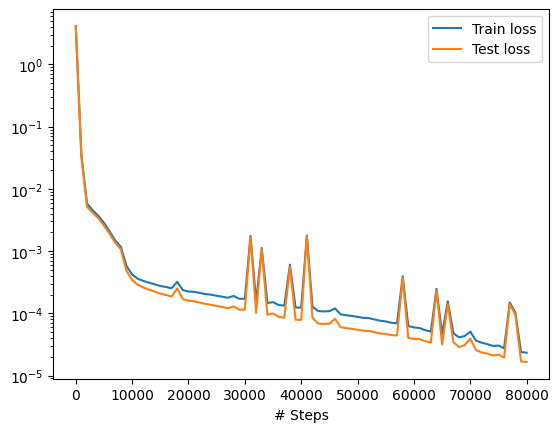

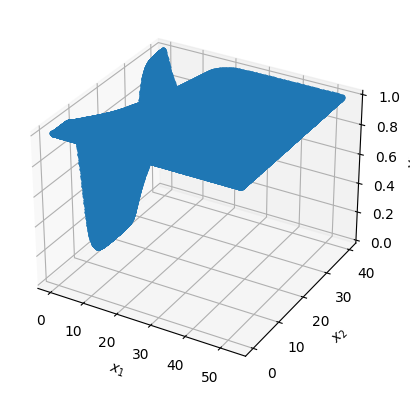

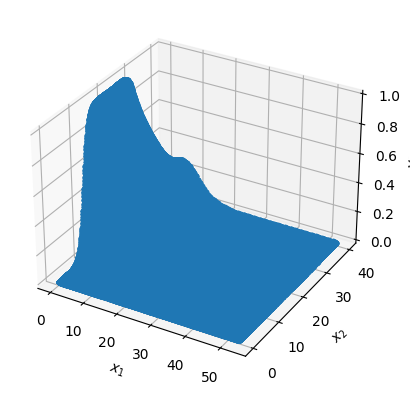

In [19]:
losshistory, train_state = model.train(iterations=80000, callbacks=[variable])
dde.saveplot(losshistory, train_state, issave=True, isplot=True)

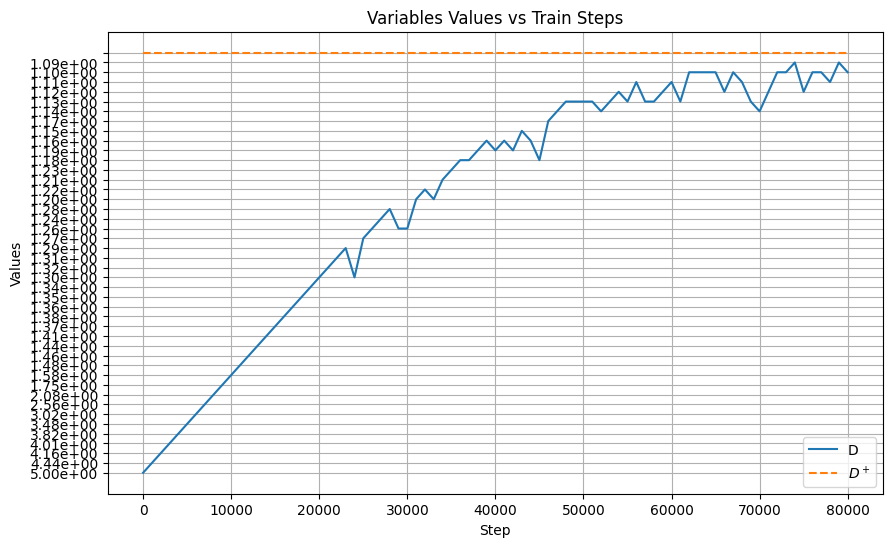

In [41]:
import numpy as np
import matplotlib.pyplot as plt

# Function to read the .dat file and parse the data
def read_dat_file(file_path):
    time = []
    values1 = []
    values2 = []
    
    with open(file_path, 'r') as file:
        for line in file:
            parts = line.split()
            time.append(int(parts[0]))
            values = parts[1].strip('[]').split(',')
            values1.append(values[0])
            values2.append(values[1])
    
    return np.array(time), np.array(values1), np.array(values2)

# File path to the .dat file
file_path = 'variables.dat'

# Read the data from the .dat file
time, values1, values2 = read_dat_file(file_path)

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(time, values1, label='D')
plt.plot(time, values2, label='$D^+$', linestyle='--')
plt.xlabel('Step')
plt.ylabel('Values')
plt.title('Variables Values vs Train Steps')
plt.legend()
plt.grid(True)
plt.show()

In [20]:
N = 100
m = 100

# Draw uniformly sampled collocation points
t_r = np.linspace(0, 2*t_lambda, N)
x_r = np.linspace(0, D_depth, m)

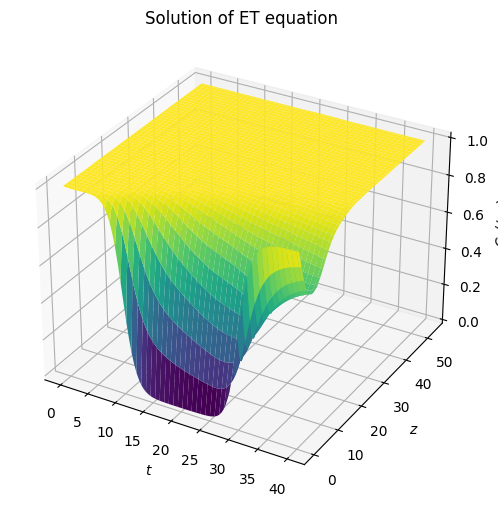

In [23]:
import matplotlib.pyplot as plt

X, T = np.meshgrid(x_r, t_r)

Xgrid = np.vstack([X.flatten(), T.flatten()]).T
y_pred = model.predict(Xgrid)

# Reshape upred
Cq = y_pred[:, 0].reshape((m, N))
Cq_plus = y_pred[:, 1].reshape((m, N))

# Surface plot of solution u(t,x)
fig = plt.figure(figsize=(9, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(T, X, Cq, cmap='viridis');
# ax.view_init(35,35)
ax.set_xlabel('$t$')
ax.set_ylabel('$z$')
ax.set_zlabel('$C_Q(t,x)$')
ax.set_title('Solution of ET equation');
plt.savefig('Cq1.png', bbox_inches='tight', dpi=300);

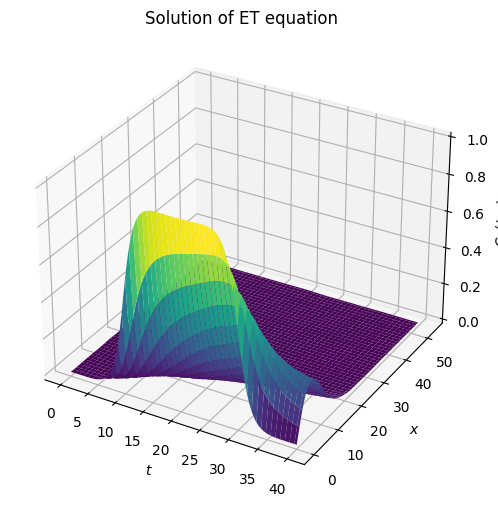

In [24]:
# Surface plot of solution u(t,x)
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(T, X, Cq_plus, cmap='viridis');
# ax.view_init(35,35)
ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.set_zlabel('$C_Q(t,x)$')
ax.set_title('Solution of ET equation');
plt.savefig('Cqp1.png', bbox_inches='tight', dpi=300);

In [32]:
import scipy
mat = scipy.io.loadmat('PINNS.mat')
aa = mat['Synthetic_Data']
bb=aa[0,0]
Cfc = bb[0]
Cfcp = bb[1]
Z_set = bb[2][0]
T_span = bb[3][0]
G1 = bb[4][0]
pot = bb[5][0]

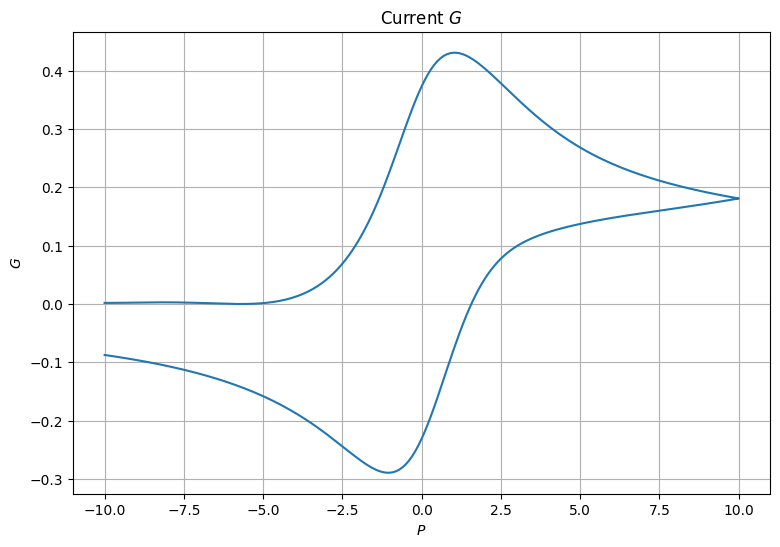

In [34]:
N = 1000
m = len(T_span)


# Draw uniformly sampled collocation points
t_r = np.linspace(0, 2*t_lambda, N)
x_r = np.linspace(0, D_depth, m)*0.0

def dydx(x, y):
    return dde.grad.jacobian(y, x, i=0, j=0)

X = np.stack([x_r, T_span], axis=1)
P = dimensionless_potential(T_span)
G = model.predict(X, operator=dydx)

# Surface plot of solution u(t,x)
fig = plt.figure(figsize=(9,6))
plt.plot(P, G)
plt.xlabel('$P$')
plt.ylabel('$G$')
plt.grid('on')
plt.title('Current $G$')
# plt.savefig('net_current.png', bbox_inches='verdis', dpi=300)
plt.show()

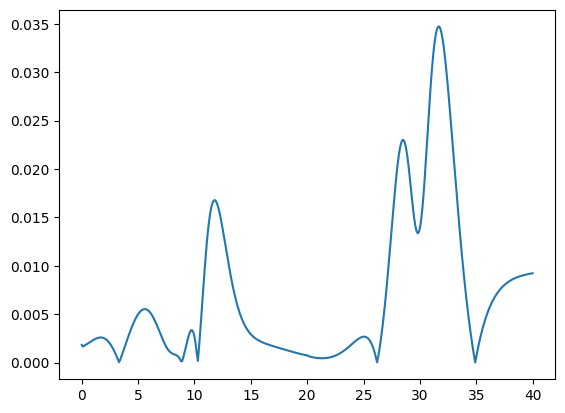

In [35]:
plt.plot(T_span, np.abs(G1 - G.reshape(-1)))
plt.show();

In [36]:
max(G1)

0.44353046909131244

In [39]:
alpha = 0.5
peak = lambda k: 0.446 + (0.247*np.sqrt(alpha) - 0.223)*(1 - np.tanh(0.63*np.log(k) + 0.189/(1 - alpha) - 0.219))
100*abs(max(G)-peak(20))/max(G)

array([3.1486056], dtype=float32)